## Complex Network Analysis: Premier League - Basic Functions

This notebook implements basic functions to load Premier League data, create a complex network for a specific season, and visualize this network.

In [14]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import warnings

# Ignore some common warnings for a cleaner display
warnings.filterwarnings('ignore', category=UserWarning, module='matplotlib')
warnings.filterwarnings('ignore', category=FutureWarning) # For newer pandas and networkx versions

### 1. Data Loading

Function to load the dataset.

In [15]:
def load_data(file_path):
    """
    Loads the dataset from a CSV file.
    
    Args:
        file_path (str): The path to the CSV file.
        
    Returns:
        pandas.DataFrame: The loaded DataFrame, or None if the file is not found.
    """
    try:
        df = pd.read_csv(file_path)
        print(f"Data loaded successfully from {file_path}")
        print(f"Dataset shape: {df.shape}")
        # Convert MatchDate to datetime if not already
        if 'MatchDate' in df.columns:
             df['MatchDate'] = pd.to_datetime(df['MatchDate'], errors='coerce')
        return df
    except FileNotFoundError:
        print(f"Error: File not found at {file_path}")
        return None

### 2. Seasonal Network Creation

Function to create an `nx.MultiDiGraph` network for a given season. The edges represent the defined metrics (using original Italian keys):
- **"Gol"**: Total goal difference of team A against team B.
- **"Tiri efficaci"**: Shooting accuracy ((ShotsOnTarget / Shots) * 100) of team A against team B.
- **"Aggressività"**: Aggressiveness score (Fouls + YellowCards + 3*RedCards) of team A against team B.
- **"Controllo"**: Control score (Corners + Shots) of team A against team B.

In [16]:
from collections import defaultdict


def create_season_network(df, season):
    """
    Creates a MultiDiGraph network for a specific season, with two directed edges
    for each metric type between pairs of teams (e.g., A's performance vs B, and B's vs A).
    This version iterates through matches once to efficiently aggregate statistics
    for each ordered pair of teams (e.g., A's performance vs B, and B's vs A).

    Args:
        df (pandas.DataFrame): The complete match DataFrame.
        season (str): The season to analyze (e.g., '2016/17').

    Returns:
        networkx.MultiDiGraph: The season's graph, or None if the season has no data.
    """
    df_season = df[df['Season'] == season].copy()

    if df_season.empty:
        print(f"No data found for season {season}.")
        return None

    # Ensure numeric columns are correct and fill NaNs
    cols_to_fill = ['FullTimeHomeGoals', 'FullTimeAwayGoals', 'HomeShots', 'AwayShots',
                    'HomeShotsOnTarget', 'AwayShotsOnTarget', 'HomeCorners', 'AwayCorners',
                    'HomeFouls', 'AwayFouls', 'HomeYellowCards', 'AwayYellowCards',
                    'HomeRedCards', 'AwayRedCards']
    for col in cols_to_fill:
        if col in df_season.columns:
            df_season[col] = pd.to_numeric(df_season[col], errors='coerce').fillna(0)
        else:
            print(f"Warning: Column {col} not found in the dataset for season {season}.")
            return None

    # Initialize a dictionary to store aggregated stats for each ORDERED pair (team1, team2)
    # Each entry will store the sum of team1's actions when playing against team2
    stats_cache = defaultdict(lambda: {
        'goals_scored': 0,
        'sot': 0,
        'total_shots': 0,
        'fouls': 0,
        'yc': 0,
        'rc': 0,
        'corners': 0
    })

    # Iterate through each match ONCE to populate the stats_cache
    for _, match in df_season.iterrows():
        ht = match['HomeTeam']
        at = match['AwayTeam']

        # Accumulate stats for HomeTeam's performance against AwayTeam in this match
        stats_cache[(ht, at)]['goals_scored'] += match['FullTimeHomeGoals']
        stats_cache[(ht, at)]['sot'] += match['HomeShotsOnTarget']
        stats_cache[(ht, at)]['total_shots'] += match['HomeShots']
        stats_cache[(ht, at)]['fouls'] += match['HomeFouls']
        stats_cache[(ht, at)]['yc'] += match['HomeYellowCards']
        stats_cache[(ht, at)]['rc'] += match['HomeRedCards']
        stats_cache[(ht, at)]['corners'] += match['HomeCorners']

        # Accumulate stats for AwayTeam's performance against HomeTeam in this match
        stats_cache[(at, ht)]['goals_scored'] += match['FullTimeAwayGoals']
        stats_cache[(at, ht)]['sot'] += match['AwayShotsOnTarget']
        stats_cache[(at, ht)]['total_shots'] += match['AwayShots']
        stats_cache[(at, ht)]['fouls'] += match['AwayFouls']
        stats_cache[(at, ht)]['yc'] += match['AwayYellowCards']
        stats_cache[(at, ht)]['rc'] += match['AwayRedCards']
        stats_cache[(at, ht)]['corners'] += match['AwayCorners']

    # Get all unique teams that participated in the season to create nodes
    all_teams_in_season = pd.concat([df_season['HomeTeam'], df_season['AwayTeam']]).unique()
    G = nx.MultiDiGraph()
    G.add_nodes_from(all_teams_in_season)

    # Build the graph using the aggregated stats from stats_cache
    for (team_a, team_b), agg_stats in stats_cache.items():
        # team_a is the source, team_b is the target for these stats

        # 1. "goals" Edge: Weight = total goals scored by team_a against team_b
        weight_goals = float(agg_stats['goals_scored'])
        G.add_edge(team_a, team_b, key="goals", weight=weight_goals)

        # 2. "shot_accuracy" Edge: Weight = accuracy of team_a against team_b
        weight_shot_accuracy = (agg_stats['sot'] / agg_stats['total_shots']) * 100 if agg_stats['total_shots'] > 0 else 0.0
        G.add_edge(team_a, team_b, key="shot_accuracy", weight=float(weight_shot_accuracy))

        # 3. "aggressiveness" Edge: Weight = aggressiveness score of team_a against team_b
        weight_aggressiveness = float(agg_stats['fouls'] + agg_stats['yc'] + 3 * agg_stats['rc'])
        G.add_edge(team_a, team_b, key="aggressiveness", weight=weight_aggressiveness)

        # 4. "control" Edge: Weight = control score of team_a against team_b
        #    (Control = Corners + Total Shots by team_a against team_b)
        weight_control = float(agg_stats['corners'] + agg_stats['total_shots'])
        G.add_edge(team_a, team_b, key="control", weight=weight_control)
        
        # Debugging block (optional, remove after confirmation)
        # if team_a == 'Arsenal' and team_b == 'Tottenham': # Adjust teams as needed for your data
        #      for metric_key, edge_attributes in G.get_edge_data(team_a, team_b).items():
        #          print(f"DEBUG: Edge from {team_a} to {team_b} (Metric: '{metric_key}', Weight: {edge_attributes.get('weight', 'N/A'):.2f})")

    print(f"Network created for season {season} with {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")
    return G

### 3. Network Visualization

Basic function to visualize the network. For complex `MultiDiGraph` graphs, visualizing all information simultaneously can be confusing. This function optionally allows visualizing edges related to a single metric.

In [17]:
def visualize_network(G, season_name, metric_to_display=None, file_name=None):
    """
    Visualizes the seasonal network.

    Args:
        G (networkx.MultiDiGraph): The graph to visualize.
        season_name (str): The name of the season (for the plot title).
        metric_to_display (str, optional): The specific metric to display (e.g., "goals").
                                           If None, tries to draw all edges (can be cluttered).
        file_name (str, optional): If provided, saves the image to the specified path.
    """
    if G is None:
        print("Graph is None, cannot visualize.")
        return

    plt.figure(figsize=(14, 10))
    pos = nx.circular_layout(G) # Circular layout, good for leagues
    
    title = f"Premier League Network - Season {season_name}"
    graph_to_draw = G
    edge_labels_to_draw = None

    if metric_to_display:
        # Create a simple graph (DiGraph) with only edges of the specified metric
        G_metric = nx.DiGraph()
        G_metric.add_nodes_from(G.nodes())
        
        # Iterate with keys=True to get the actual edge key
        for u, v, edge_key, data in G.edges(keys=True, data=True):
            if edge_key == metric_to_display: # Check against edge_key directly
                G_metric.add_edge(u, v, weight=data['weight'])
        
        if not G_metric.edges():
            print(f"No edges found for metric '{metric_to_display}'. Displaying base node layout.")
            # Draw only nodes if no edges for the metric
            nx.draw_networkx_nodes(G, pos, node_size=2000, node_color='skyblue', alpha=0.9)
            nx.draw_networkx_labels(G, pos, font_size=9)
        else:
            graph_to_draw = G_metric
            title += f" - Metric: {metric_to_display}"
            # Prepare weight labels for edges of the selected metric
            edge_labels_to_draw = {(u, v): f"{d['weight']:.2f}" for u, v, d in G_metric.edges(data=True)}
            # Draw nodes, edges, and labels for the specific metric graph
            nx.draw_networkx_nodes(graph_to_draw, pos, node_size=2000, node_color='skyblue', alpha=0.9)
            nx.draw_networkx_labels(graph_to_draw, pos, font_size=9)
            nx.draw_networkx_edges(graph_to_draw, pos, arrowstyle='->', arrowsize=15, width=1.5, edge_color='teal')
            if edge_labels_to_draw:
                nx.draw_networkx_edge_labels(graph_to_draw, pos, edge_labels=edge_labels_to_draw, font_size=7)

    else: # No specific metric, draw the full MultiDiGraph
        nx.draw_networkx_nodes(graph_to_draw, pos, node_size=2000, node_color='skyblue', alpha=0.9)
        nx.draw_networkx_labels(graph_to_draw, pos, font_size=9)
        # Basic drawing for MultiDiGraph (can be cluttered)
        # Drawing all edges with arrows. For better distinction, you might color by 'key'
        nx.draw_networkx_edges(graph_to_draw, pos, arrowstyle='->', arrowsize=15, 
                               edge_color='gray', alpha=0.5, connectionstyle='arc3,rad=0.1')
        print("Displaying all edges for MultiDiGraph. For clarity, consider specifying 'metric_to_display'.")
    
    plt.title(title, fontsize=15)
    plt.axis('off')
    
    if file_name:
        try:
            plt.savefig(file_name, format='PNG', dpi=300)
            print(f"Plot saved as {file_name}")
        except Exception as e:
            print(f"Error saving plot: {e}")
    plt.show()

### 4. Example Usage

Data loaded successfully from ../data/epl_final.csv
Dataset shape: (9380, 22)
Network created for season 2016/17 with 20 nodes and 1520 edges.
Plot saved as network_2016-17_goals.png


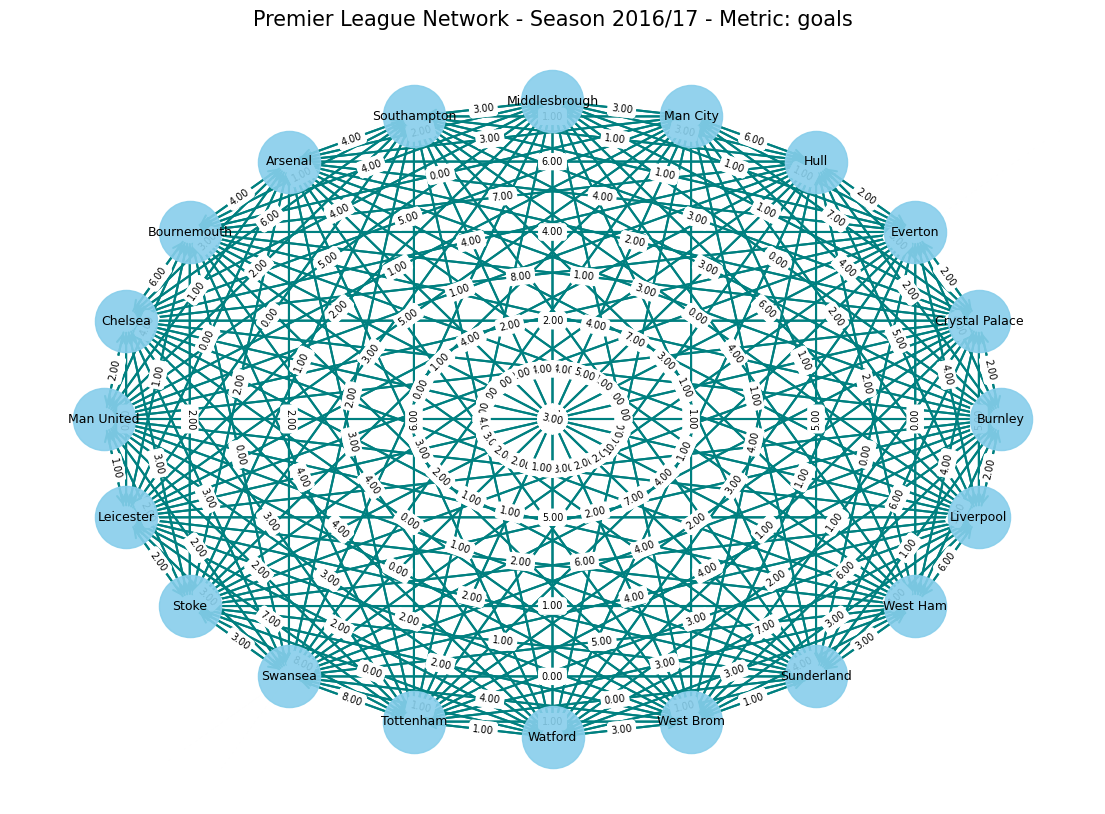

In [18]:
# Path to the CSV file
csv_path = '../data/epl_final.csv'

# Load the data
epl_df = load_data(csv_path)

if epl_df is None:
    print("Cannot proceed without data.")


# Choose a season for analysis
selected_season = '2016/17' # Example

# Create the network for the selected season
season_network = create_season_network(epl_df, selected_season)


# Visualize the network for a specific metric (e.g., "goals")
visualize_network(season_network, selected_season, metric_to_display="goals", file_name=f'network_{selected_season.replace("/", "-")}_goals.png')

Plot saved as network_2016-17_shot_accuracy.png


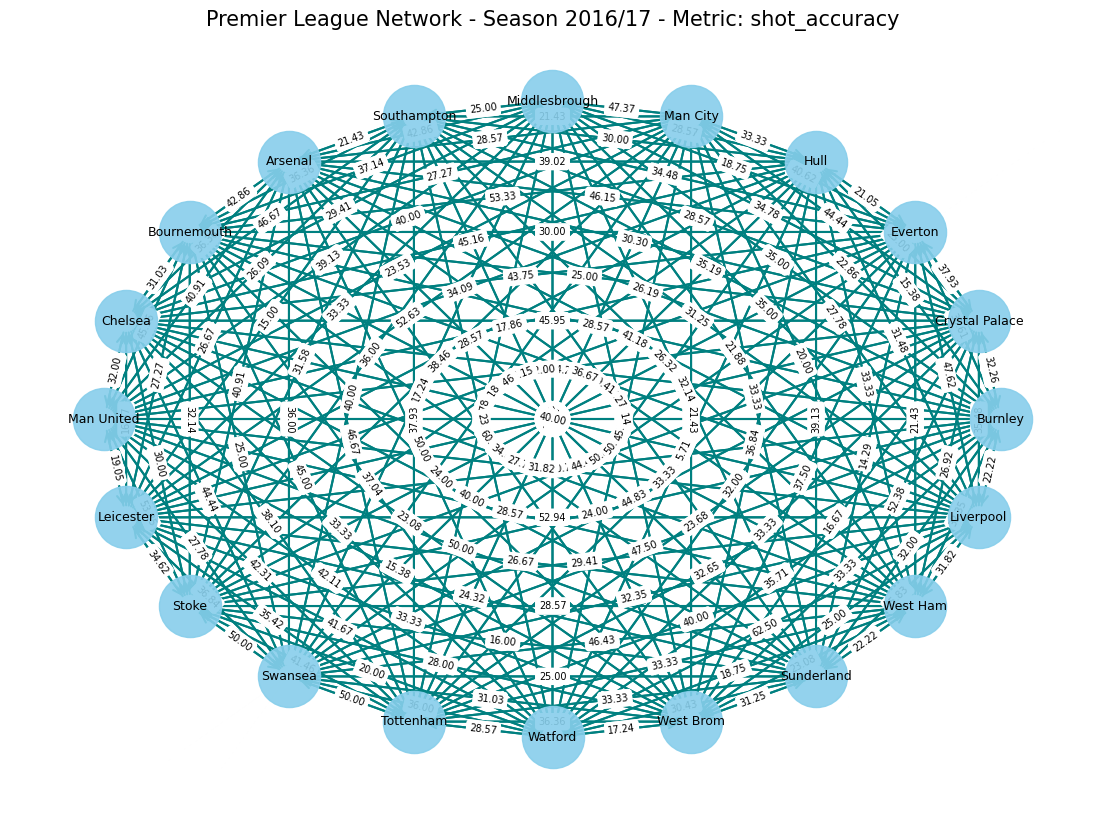

In [19]:
# Visualize the network for another metric (e.g., "shot_accuracy"
visualize_network(season_network, selected_season, metric_to_display="shot_accuracy", file_name=f'network_{selected_season.replace("/", "-")}_shot_accuracy.png')

In [20]:
# Example of how to access edge data:
print("\nExample edge data (e.g., Arsenal -> a Tottenham team):")
team1_name_example = 'Arsenal'
team2_partial_name_example = 'Tottenham' # We'll search for a team containing this string

actual_team1_name = None
actual_team2_name = None
available_nodes = list(season_network.nodes())

for node_name in available_nodes:
    if team1_name_example in node_name: # Simple check, might need refinement for exact match
        actual_team1_name = node_name
    if team2_partial_name_example in node_name:
        actual_team2_name = node_name

if actual_team1_name and actual_team2_name and season_network.has_edge(actual_team1_name, actual_team2_name):
    print(f"Edges from {actual_team1_name} to {actual_team2_name}:")
    # Correct iteration for MultiDiGraph's get_edge_data().items()
    for metric_key, key_dict_val in season_network.get_edge_data(actual_team1_name, actual_team2_name).items():
         print(f"  Metric: {metric_key}, Weight: {key_dict_val.get('weight', 'N/A'):.2f}")
elif actual_team1_name and actual_team2_name:
    print(f"  No direct edges found from {actual_team1_name} to {actual_team2_name} in the graph for season {selected_season}.")
else:
    print(f"  Could not find one or both teams ('{team1_name_example}', '{team2_partial_name_example}') as nodes in the network for this season.")


Example edge data (e.g., Arsenal -> a Tottenham team):
Edges from Arsenal to Tottenham:
  Metric: goals, Weight: 1.00
  Metric: shot_accuracy, Weight: 22.22
  Metric: aggressiveness, Weight: 30.00
  Metric: control, Weight: 39.00


In [21]:
# Assuming 'epl_df' is your DataFrame loaded with load_data(csv_path)
if epl_df is not None:
    # Get unique team names from both HomeTeam and AwayTeam columns
    home_teams = epl_df['HomeTeam'].unique()
    away_teams = epl_df['AwayTeam'].unique()
    
    # Combine them and get unique names
    all_teams = pd.Series(list(home_teams) + list(away_teams)).unique()
    all_teams.sort() # Optional: sort them alphabetically
    
    print("Unique team names in the dataset:")
    for team in all_teams:
        print(team)
else:
    print("DataFrame not loaded. Cannot print team names.")

Unique team names in the dataset:
Arsenal
Aston Villa
Birmingham
Blackburn
Blackpool
Bolton
Bournemouth
Bradford
Brentford
Brighton
Burnley
Cardiff
Charlton
Chelsea
Coventry
Crystal Palace
Derby
Everton
Fulham
Huddersfield
Hull
Ipswich
Leeds
Leicester
Liverpool
Luton
Man City
Man United
Middlesbrough
Newcastle
Norwich
Nott'm Forest
Portsmouth
QPR
Reading
Sheffield United
Southampton
Stoke
Sunderland
Swansea
Tottenham
Watford
West Brom
West Ham
Wigan
Wolves
